In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/DL/traffic_Data/DATA'
import pandas as pd
labels_df = pd.read_csv('/content/drive/MyDrive/DL/labels.csv')

In [36]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [37]:
images = []
labels = []

In [38]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        class_name = labels_df.loc[labels_df['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [39]:
max_height = max(img.shape[0] for img in images)
max_width = max(img.shape[1] for img in images)

In [40]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)

In [41]:
images = np.array(resized_images)
labels = np.array(labels)

In [42]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = np.max(label_counts)

In [43]:
print(images.shape, labels.shape)

(4173, 224, 224, 3) (4173,)


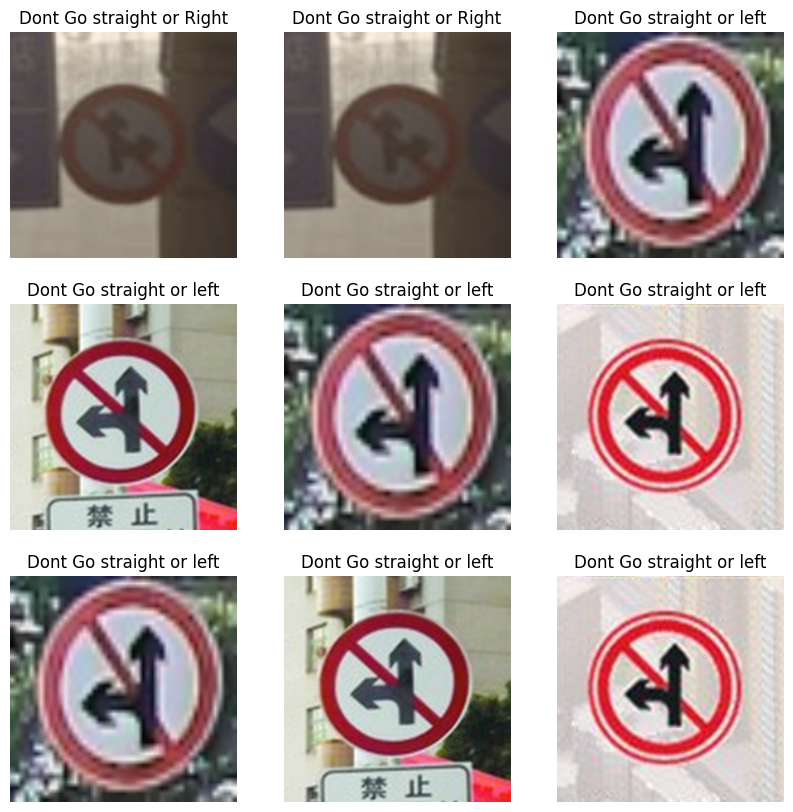

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

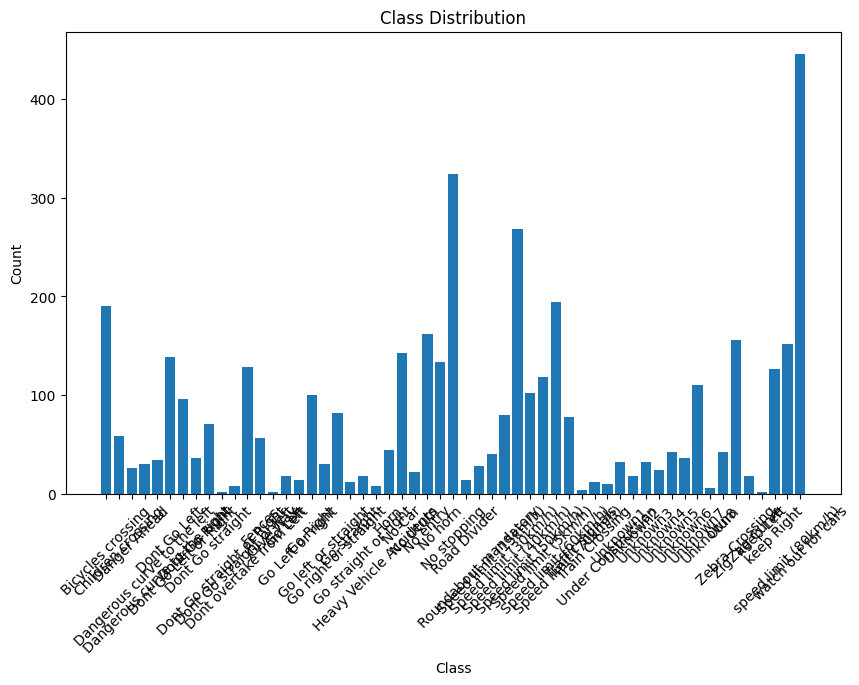

In [17]:

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [44]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [45]:
for layer in base_model.layers:
    layer.trainable = False


In [46]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(len(unique_labels), activation='softmax')(x)

In [47]:
densenet_model = Model(inputs=base_model.input, outputs=output)

In [48]:
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
densenet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [49]:
checkpoint_path = "model_weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='min',
                                      save_freq='epoch')

In [50]:
X_resized = np.array(resized_images)
X_train_resized, X_test_resized, y_train, y_test = train_test_split(X_resized, labels, test_size=0.2, random_state=42)


In [51]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [52]:
history = densenet_model.fit(X_train_resized, y_train_encoded,
                              epochs=10,
                              batch_size=32,
                              validation_data=(X_test_resized, y_test_encoded),
                              callbacks=[checkpoint_callback])

Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 3.1454 - accuracy: 0.3969
Epoch 1: val_loss improved from inf to 1.55982, saving model to model_weights.h5
105/105 [==============================] - 812s 8s/step - loss: 3.1454 - accuracy: 0.3969 - val_loss: 1.5598 - val_accuracy: 0.5916
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 1.2191 - accuracy: 0.6827
Epoch 2: val_loss improved from 1.55982 to 1.00137, saving model to model_weights.h5
105/105 [==============================] - 801s 8s/step - loss: 1.2191 - accuracy: 0.6827 - val_loss: 1.0014 - val_accuracy: 0.7042
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.7586 - accuracy: 0.7966
Epoch 3: val_loss improved from 1.00137 to 0.69286, saving model to model_weights.h5
105/105 [==============================] - 791s 8s/step - loss: 0.7586 - accuracy: 0.7966 - val_loss: 0.6929 - val_accuracy: 0.8180
Epoch 4/10
105/105 [==============================] - ETA: 0s - l

In [53]:
test_loss, test_acc = densenet_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

27/27 [==============================] - 146s 5s/step - loss: 0.1968 - accuracy: 0.9569
Test Accuracy: 0.9568862318992615


In [54]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in densenet_model.layers]
activation_model = Model(inputs=densenet_model.input, outputs=layer_outputs)
sample_image = X_train_resized[0:1]
activations = activation_model.predict(sample_image)

1/1 [==============================] - 4s 4s/step


In [55]:
import matplotlib.pyplot as plt

# Assuming activations is the list of activations obtained from DenseNet121 model
for layer_name, activation in zip(densenet_model.layers, activations):
    print(layer_name.name, activation.shape)
    if len(activation.shape) == 4:  # Check if the activation is of shape (batch_size, height, width, channels)
        plt.figure(figsize=(15, 5))
        for i in range(3):  # Display three images from each layer in each row
            plt.subplot(1, 3, i+1)
            plt.imshow(activation[0, :, :, i], cmap='viridis')  # Visualize each channel
            plt.title(f'Channel {i+1}')
            plt.axis('off')
        plt.suptitle(layer_name.name)
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

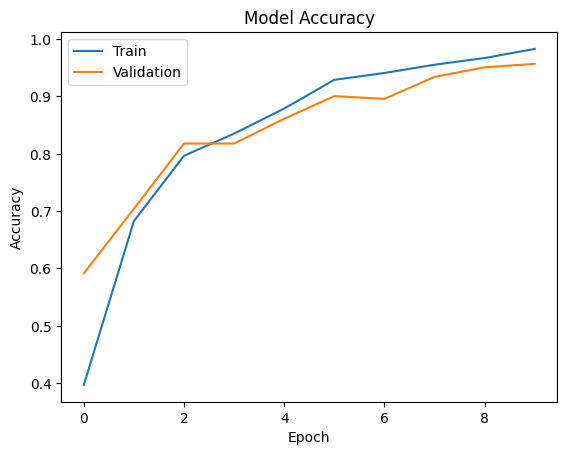

In [56]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history of the DenseNet121 model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


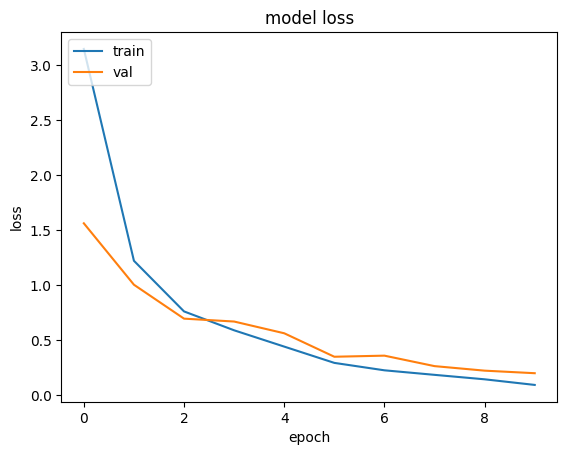

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

27/27 [==============================] - 189s 7s/step


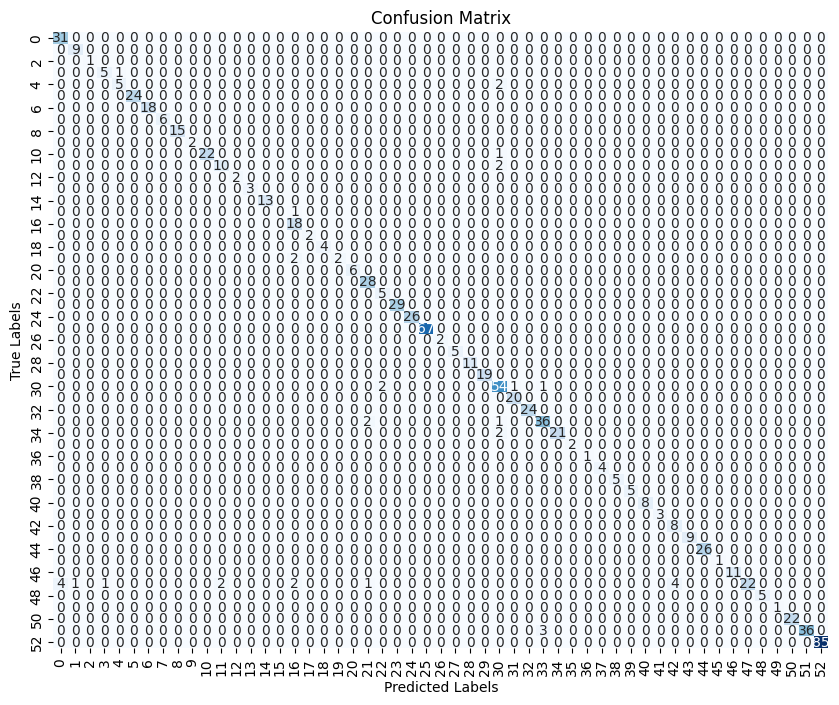

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        31
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         1
           3       0.83      0.83      0.83         6
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        15
          10       1.00      1.00      1.00         2
          11       1.00      0.96      0.98        23
          12       0.83      0.83      0.83        12
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00        13
          17       0.00      0.00      0.00         1
          18       0.78      1.00      0.88        18
          19       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = densenet_model.predict(X_test_resized)

y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test_encoded, y_pred_labels))

1/1 [==============================] - 1s 519ms/step


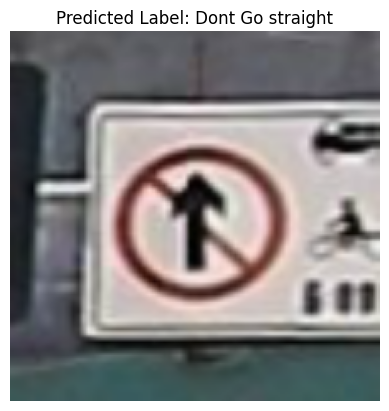

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = '/content/drive/MyDrive/DL/traffic_Data/TEST/010_1_0029_1_j.png'
input_image = cv2.imread(image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
input_image = cv2.resize(input_image, (224, 224))  # Resize to match model input size
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Predict the label
prediction = densenet_model.predict(input_image)
predicted_label = np.argmax(prediction)

# Decode the predicted label
predicted_class = label_encoder.inverse_transform([predicted_label])

# Display the image along with its predicted label
plt.imshow(input_image[0])
plt.title(f'Predicted Label: {predicted_class[0]}')
plt.axis('off')
plt.show()
